In [1]:
from pathlib import Path
from typing import *
import shutil

import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from tqdm import tqdm 
from scipy import sparse
import scanpy as sc 

from scrna_atlas import settings, utils

In [2]:
cell_type_df = pd.read_csv(
    settings.HPA_DATA_LOC / 'rna_single_cell_cluster_description.tsv',
    sep='\t',
)
cell_type_df

,Tissue,Cluster,Cell type,Cell type group,Cell count
0,Adipose tissue,c-0,Fibroblasts,Mesenchymal cells,14945
1,Adipose tissue,c-1,T-cells,Blood & immune cells,10011
2,Adipose tissue,c-2,T-cells,Blood & immune cells,7279
3,Adipose tissue,c-3,T-cells,Blood & immune cells,7200
4,Adipose tissue,c-4,Nk-cells,Blood & immune cells,5823
...,...,...,...,...,...
552,Vascular,c-15,Endothelial cells,Endothelial cells,237
553,Vascular,c-16,Endothelial cells,Endothelial cells,204
554,Vascular,c-17,Smooth muscle cells,Muscle cells,192
555,Vascular,c-18,Schwann cells,Glial cells,175


In [3]:
cell_expression_df = pd.read_csv(
    settings.HPA_DATA_LOC / 'rna_single_cell_type_tissue.tsv',
    sep='\t',
)   
cell_expression_df

,Gene,Gene name,Tissue,Cluster,Cell type,Read count,nTPM
0,ENSG00000000003,TSPAN6,testis,c-0,leydig cells,86,29.0
1,ENSG00000000003,TSPAN6,testis,c-1,spermatocytes,152,19.8
2,ENSG00000000003,TSPAN6,testis,c-2,late spermatids,1330,2089.7
3,ENSG00000000003,TSPAN6,testis,c-3,early spermatids,1898,368.5
4,ENSG00000000003,TSPAN6,testis,c-4,spermatogonia,285,30.5
...,...,...,...,...,...,...,...
11185669,ENSG00000288695,ENSG00000288695,ovary,c-12,ovarian stromal cells,0,0.0
11185670,ENSG00000288695,ENSG00000288695,ovary,c-13,granulosa cells,0,0.0
11185671,ENSG00000288695,ENSG00000288695,ovary,c-14,mixed immune cells,0,0.0
11185672,ENSG00000288695,ENSG00000288695,ovary,c-15,oocytes,0,0.0


In [4]:
gene_df = cell_expression_df.loc[:, 
    ['Gene', 'Gene name']
].drop_duplicates().rename(
    {'Gene name': 'gene_name', 'Gene': 'gene'},
    axis=1,
)
gene_df

,gene,gene_name
0,ENSG00000000003,TSPAN6
557,ENSG00000000005,TNMD
1114,ENSG00000000419,DPM1
1671,ENSG00000000457,SCYL3
2228,ENSG00000000460,C1orf112
...,...,...
11182889,ENSG00000288677,HRURF
11183446,ENSG00000288678,ENSG00000288678
11184003,ENSG00000288681,ENSG00000288681
11184560,ENSG00000288684,ENSG00000288684


In [5]:
cluster_tissue_type_df = cell_expression_df.loc[:,
    ['Tissue', 'Cluster', 'Cell type']
].drop_duplicates().rename(
    {'Tissue': 'tissue', 'Cluster': 'cluster', 'Cell type': 'cell_type'},
    axis=1,
)
cluster_tissue_type_df['tissue'] = cluster_tissue_type_df['tissue'].map(lambda x: x.replace(' ', '_'))
cluster_tissue_type_df['cell_type'] = cluster_tissue_type_df['cell_type'].map(lambda x: x.replace(' ', '_'))
cluster_tissue_type_df

,tissue,cluster,cell_type
0,testis,c-0,leydig_cells
1,testis,c-1,spermatocytes
2,testis,c-2,late_spermatids
3,testis,c-3,early_spermatids
4,testis,c-4,spermatogonia
...,...,...,...
552,ovary,c-12,ovarian_stromal_cells
553,ovary,c-13,granulosa_cells
554,ovary,c-14,mixed_immune_cells
555,ovary,c-15,oocytes


In [23]:
adatas = {}

tissues = [f for f in settings.HPA_DATA_LOC.iterdir() if f.is_dir()]
for t in tqdm(tissues, total=len(tissues)):
    print(t.stem)
    (Path('/efs/expression_atlas/scrna') / t.stem).mkdir(exist_ok=True, parents=True)

    adata = utils.build_hpa_tissue_adata(
        t, 
        cluster_tissue_type_df,
        gene_df,
    )
    adata.write_h5ad(
        Path('/efs/expression_atlas/scrna') / 'hpa' / t.stem / 'adata.h5ad'
    )

  0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


adipose_tissue
reading counts...


20082it [04:42, 71.06it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  3%|▎         | 1/31 [05:05<2:32:45, 305.53s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


bone_marrow
reading counts...


20082it [00:11, 1783.73it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  6%|▋         | 2/31 [05:17<1:04:19, 133.09s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


brain
reading counts...


20082it [06:11, 54.01it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 10%|▉         | 3/31 [12:48<2:09:52, 278.29s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


breast
reading counts...


20082it [02:45, 121.26it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 13%|█▎        | 4/31 [15:47<1:47:34, 239.06s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


bronchus
reading counts...


20082it [01:29, 225.24it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 16%|█▌        | 5/31 [17:23<1:21:10, 187.32s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


colon
reading counts...


20082it [00:18, 1108.69it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 19%|█▉        | 6/31 [17:44<54:26, 130.67s/it]  /tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


endometrium
reading counts...


20082it [03:17, 101.56it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 23%|██▎       | 7/31 [21:21<1:03:38, 159.10s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


esophagus
reading counts...


20082it [00:34, 581.83it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 26%|██▌       | 8/31 [21:59<46:07, 120.33s/it]  /tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


eye
reading counts...


20082it [00:29, 672.71it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 29%|██▉       | 9/31 [22:30<33:57, 92.59s/it] /tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


fallopian_tube
reading counts...


20082it [03:54, 85.52it/s] 


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 32%|███▏      | 10/31 [26:50<50:25, 144.08s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


heart_muscle
reading counts...


20082it [00:19, 1033.82it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 35%|███▌      | 11/31 [27:11<35:28, 106.42s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


kidney
reading counts...


20082it [00:59, 339.13it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 39%|███▊      | 12/31 [28:13<29:27, 93.02s/it] /tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


liver
reading counts...


20082it [00:35, 562.41it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 42%|████▏     | 13/31 [28:51<22:55, 76.44s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


lung
reading counts...


20082it [01:50, 181.74it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 45%|████▌     | 14/31 [30:56<25:49, 91.15s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


lymph_node
reading counts...


20082it [00:28, 698.62it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 48%|████▊     | 15/31 [31:27<19:25, 72.86s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


ovary
reading counts...


20082it [02:07, 157.88it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 52%|█████▏    | 16/31 [33:43<22:59, 91.97s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


pancreas
reading counts...


20082it [00:21, 947.47it/s] 


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 55%|█████▍    | 17/31 [34:08<16:46, 71.89s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


pbmc
reading counts...


20082it [00:17, 1179.83it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 58%|█████▊    | 18/31 [34:27<12:06, 55.90s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


placenta
reading counts...


20082it [01:41, 197.59it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 61%|██████▏   | 19/31 [36:27<15:02, 75.20s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


prostate
reading counts...


20082it [01:06, 301.20it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 65%|██████▍   | 20/31 [37:40<13:38, 74.44s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


rectum
reading counts...


20082it [00:10, 2005.70it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 68%|██████▊   | 21/31 [37:52<09:17, 55.70s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


salivary_gland
reading counts...


20082it [01:43, 193.82it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 71%|███████   | 22/31 [39:47<11:01, 73.51s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


skeletal_muscle
reading counts...


20082it [01:23, 241.52it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 74%|███████▍  | 23/31 [41:16<10:25, 78.20s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


skin
reading counts...


20082it [01:13, 273.51it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 77%|███████▋  | 24/31 [42:34<09:06, 78.12s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


small_intestine
reading counts...


20082it [00:18, 1067.05it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 81%|████████  | 25/31 [42:55<06:06, 61.08s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


spleen
reading counts...


20082it [00:14, 1372.56it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 84%|████████▍ | 26/31 [43:12<03:58, 47.61s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


stomach
reading counts...


20082it [00:18, 1097.62it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 87%|████████▋ | 27/31 [43:32<02:37, 39.33s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


testis
reading counts...


20082it [00:24, 824.71it/s] 


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 90%|█████████ | 28/31 [44:00<01:48, 36.05s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


thymus
reading counts...


20082it [01:28, 227.63it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 94%|█████████▎| 29/31 [45:41<01:50, 55.42s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


tongue
reading counts...


20082it [01:11, 280.22it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
 97%|█████████▋| 30/31 [47:05<01:04, 64.07s/it]/tmp/ipykernel_505976/3286860472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['cluster'] = obs['cluster'].astype(str)


vascular
reading counts...


20082it [00:39, 505.06it/s]


finished reading...
converting to sparse...


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████| 31/31 [47:52<00:00, 92.65s/it]


In [32]:
list(Path('/efs/expression_atlas/scrna/hpa/').glob('*/*.h5ad'))

[PosixPath('/efs/expression_atlas/scrna/hpa/rectum/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/salivary_gland/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/placenta/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/kidney/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/bronchus/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/heart_muscle/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/brain/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/testis/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/prostate/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/tongue/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/liver/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/pbmc/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/thymus/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/lung/adata.h5ad'),
 PosixPath('/efs/expression_atlas/scrna/hpa/adipose_tissue/adata.h5ad'),
 Po

In [7]:
hpa_files = list(Path('/efs/expression_atlas/scrna/hpa/').glob('*/*.h5ad'))

for fh in hpa_files:
    print(fh.stem)
    utils.process_hpa_atlas_adatas(
        ad.read_h5ad(fh, backed='r'),
        fh.stem,
        out_loc=settings.DATA_LOC / 'hpa' / 'tmp' / fh.parts[-2],
        use_rep='X_pca',
        umap_key='X_umap',
    )

adata


/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-pac

adata


100%|██████████| 56/56 [03:17<00:00,  3.53s/it]


adata


100%|██████████| 43/43 [03:31<00:00,  4.91s/it]


adata


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


adata


100%|██████████| 59/59 [02:13<00:00,  2.26s/it]


adata


100%|██████████| 26/26 [00:11<00:00,  2.19it/s]


adata


100%|██████████| 35/35 [14:53<00:00, 25.53s/it]


adata


100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


adata


100%|██████████| 63/63 [02:06<00:00,  2.01s/it]


adata


100%|██████████| 42/42 [02:22<00:00,  3.40s/it]


adata


100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


adata


100%|██████████| 24/24 [00:10<00:00,  2.30it/s]


adata


100%|██████████| 61/61 [03:39<00:00,  3.60s/it]


adata


100%|██████████| 40/40 [03:32<00:00,  5.32s/it]


adata


100%|██████████| 44/44 [06:12<00:00,  8.47s/it]


adata


100%|██████████| 75/75 [06:00<00:00,  4.80s/it]


adata


100%|██████████| 30/30 [01:16<00:00,  2.54s/it]


adata


100%|██████████| 44/44 [02:28<00:00,  3.37s/it]


adata


100%|██████████| 63/63 [07:12<00:00,  6.87s/it]


adata


100%|██████████| 58/58 [08:07<00:00,  8.40s/it]


adata


100%|██████████| 46/46 [01:16<00:00,  1.67s/it]


adata


100%|██████████| 32/32 [01:12<00:00,  2.25s/it]


adata


100%|██████████| 23/23 [00:30<00:00,  1.34s/it]


adata


100%|██████████| 38/38 [00:14<00:00,  2.64it/s]


adata


100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


adata


100%|██████████| 22/22 [00:15<00:00,  1.45it/s]


adata


100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


adata


100%|██████████| 42/42 [00:10<00:00,  3.84it/s]


adata


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


adata


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


adata


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


In [2]:
hpa_files = list(Path('/efs/expression_atlas/scrna/hpa/').glob('*/*.h5ad'))
adatas = []
keys = []

for fh in tqdm(hpa_files):
    if fh.parts[-2] == 'all':
        continue
    keys.append(fh.parts[-2])
    sub_adata = ad.read_h5ad(fh)
    sub_adata.obs['cluster'] = sub_adata.obs['cluster'].map(lambda x: f'{fh.parts[-2]}_{x}')
    if sub_adata.shape[0] > 5000:
        sub_adata = sc.pp.subsample(sub_adata, n_obs=5000, random_state=42, copy=True)
    adatas.append(sub_adata)

atlas_adata = ad.concat(
    adatas, 
    join='outer', 
    keys=keys,
    fill_value=0.0,
)


100%|██████████| 31/31 [01:23<00:00,  2.69s/it]
/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
atlas_adata.obsm['X_pca'] = sc.tl.pca(atlas_adata.X.astype(float))

In [4]:
sc.pp.neighbors(
    atlas_adata,
    n_neighbors=15,
    n_pcs=50,
    use_rep='X_pca',
)

/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ec2-user/anaconda/envs/singlecell/lib/python3.9/site-pac

In [5]:
sc.tl.louvain(
    atlas_adata,
    resolution=1.0,
)

atlas_adata.obs['tissue_cell_type'] = atlas_adata.obs.apply(
    lambda x: f'{x.tissue}__{x.cell_type}'.replace(' ', '_'),
    axis=1,
)

In [6]:
sc.tl.umap(atlas_adata)

In [7]:

if 'gene_name' not in atlas_adata.var.columns:
    atlas_adata.var = atlas_adata.var.merge(
        utils.pull_genes_gtf(settings.GTF_HUMAN_FH).loc[
            :,['gene_type', 'gene_name'],
        ],
        how='left',
        left_index=True,
        right_index=True,
    )

In [8]:
atlas_adata.uns['title'] = 'scRNA HPA - All'
(settings.DATA_LOC / 'hpa' / 'tmp' / 'all').mkdir(exist_ok=True)
padata = utils.pseudobulk_adata(
    atlas_adata,
    'louvain',
    'tissue_cell_type',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)

padata.write_h5ad(
    settings.DATA_LOC / 'hpa' / 'tmp' /'all' / f'adata_pseuodobulk.h5ad'
)

100%|██████████| 1360/1360 [01:49<00:00, 12.47it/s]
... storing 'tissue_cell_type' as categorical
... storing 'gene_type' as categorical
... storing 'gene_name' as categorical


In [10]:
padata_tissue = utils.pseudobulk_adata(
    atlas_adata,
    'tissue',
    'tissue',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)


100%|██████████| 31/31 [01:47<00:00,  3.48s/it]


In [11]:
padata_celltype = utils.pseudobulk_adata(
    atlas_adata,
    'cell_type',
    'cell_type',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)


100%|██████████| 85/85 [01:35<00:00,  1.12s/it]


In [12]:
padata_cluster = utils.pseudobulk_adata(
    atlas_adata,
    'cluster',
    'cluster',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)

100%|██████████| 555/555 [01:31<00:00,  6.09it/s]


In [13]:
padata_louvain = utils.pseudobulk_adata(
    atlas_adata,
    'louvain',
    'louvain',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)

100%|██████████| 53/53 [01:34<00:00,  1.79s/it]


In [14]:
padata_tissuecelltype = utils.pseudobulk_adata(
    atlas_adata,
    'tissue_cell_type',
    'tissue_cell_type',
    min_cells=5,
    min_counts=200,
    umap_key='X_umap',
    calc_tpm=True,
    normalize_length=False,
)

100%|██████████| 229/229 [01:34<00:00,  2.42it/s]


In [15]:
padata.var['tau__tissue'] = calc_adata_tau(padata_tissue, return_tau=True)
padata.var['tau__cell_type'] = calc_adata_tau(padata_celltype, return_tau=True)
padata.var['tau__cluster'] = calc_adata_tau(padata_cluster, return_tau=True)
padata.var['tau__louvain'] = calc_adata_tau(padata_louvain, return_tau=True)
padata.var['tau__tissue_cell_type'] = calc_adata_tau(padata_tissuecelltype, return_tau=True)
padata.var['tau__pseudobulk'] = calc_adata_tau(padata, return_tau=True)

/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)
/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)
/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)
/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)
/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)
/tmp/ipykernel_6425/1313015571.py:14: RuntimeWarning: invalid value encountered in divide
  xi = l / l.max(axis=0)


(array([  12.,   51.,   80.,  121.,  159.,  279.,  313.,  448.,  474.,
         587.,  654.,  791.,  761.,  795.,  800.,  868.,  841.,  881.,
         792.,  794.,  840.,  937., 1107., 1728., 4485.]),
 array([0.16820392, 0.20147576, 0.23474761, 0.26801945, 0.30129129,
        0.33456314, 0.36783498, 0.40110682, 0.43437867, 0.46765051,
        0.50092235, 0.53419419, 0.56746604, 0.60073788, 0.63400972,
        0.66728157, 0.70055341, 0.73382525, 0.7670971 , 0.80036894,
        0.83364078, 0.86691263, 0.90018447, 0.93345631, 0.96672816,
        1.        ]),
 <BarContainer object of 25 artists>)

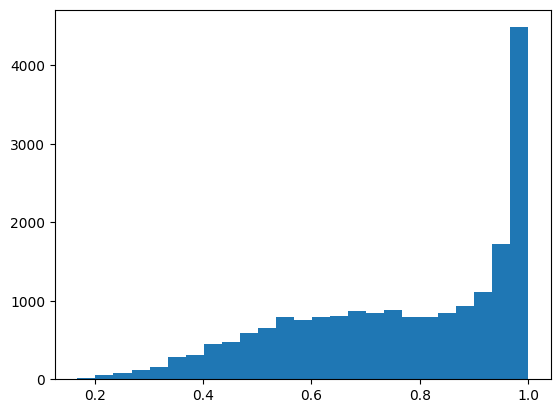

In [16]:
plt.hist(
    padata.var['tau__pseudobulk'],
    bins=25,
)

In [17]:
padata.var.sort_values('tau__pseudobulk', ascending=False).head(50)

,gene_type,gene_name,tau__tissue,tau__cell_type,tau__cluster,tau__louvain,tau__tissue_cell_type,tau__pseudobulk
gene,,,,,,,,
ENSG00000176219,protein_coding,OR11H6,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000184394,protein_coding,OR4N5,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000280778,protein_coding,CH17-270A2.2,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000177489,protein_coding,OR2G2,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000129965,protein_coding,INS-IGF2,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000187612,protein_coding,OR5W2,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000281887,protein_coding,GIMAP1-GIMAP5,1.0,1.0,0.996848,1.000000,1.0,1.0
ENSG00000223417,protein_coding,TRIM49D1,1.0,1.0,1.000000,1.000000,1.0,1.0
ENSG00000264668,protein_coding,RP13-582O9.6,1.0,1.0,1.000000,1.000000,1.0,1.0


In [10]:
for p in list((settings.DATA_LOC / 'hpa' / 'tmp').glob('*/adata_pseuodobulk.h5ad')):
    print(Path(*[_p for i,_p in enumerate(p.parts) if i != 6]))
    shutil.copy(
        p,
        Path(*[_p for i,_p in enumerate(p.parts) if i != 6])
    )

/home/ec2-user/scrna/data/hpa/rectum/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/salivary_gland/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/placenta/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/kidney/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/bronchus/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/heart_muscle/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/brain/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/testis/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/prostate/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/tongue/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/liver/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/pbmc/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/thymus/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/lung/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/adipose_tissue/adata_pseuodobulk.h5ad
/home/ec2-user/scrna/data/hpa/breast/adata_pseuodobulk.h5ad
/home/ec2-user/scr

In [19]:
s_tissue = utils.label_expression_similarity(
    padata_tissue.layers['ntpm'],
    padata_tissue.obs,
    padata_tissue.var,
    specificity_column = 'tissue',
)
s_celltype = utils.label_expression_similarity(
    padata_celltype.layers['ntpm'],
    padata_celltype.obs,
    padata_celltype.var,
    specificity_column = 'cell_type',
)
s_tissuecelltype = utils.label_expression_similarity(
    padata_tissuecelltype.layers['ntpm'],
    padata_tissuecelltype.obs,
    padata_tissuecelltype.var,
    specificity_column = 'tissue_cell_type',
)
s_cluster = utils.label_expression_similarity(
    padata_cluster.layers['ntpm'],
    padata_cluster.obs,
    padata_cluster.var,
    specificity_column = 'cluster',
)
s_louvain = utils.label_expression_similarity(
    padata_louvain.layers['ntpm'],
    padata_louvain.obs,
    padata_louvain.var,
    specificity_column = 'louvain',
)
s_pseudobulk = utils.label_expression_similarity(
    padata.layers['ntpm'],
    padata.obs,
    padata.var,
)
padata.uns['specificity'] = {}
padata.uns['specificity']['tissue'] = s_tissue
padata.uns['specificity']['cell_type'] = s_celltype
padata.uns['specificity']['tissue_cell_type'] = s_tissuecelltype
padata.uns['specificity']['cluster'] = s_cluster
padata.uns['specificity']['louvain'] = s_louvain
padata.uns['specificity']['pseudobulk'] = s_pseudobulk

In [451]:
s_tissuecelltype.loc[
        padata_tissuecelltype.var['gene_name'] == 'NPY'
].T.iloc[:,0].sort_values(ascending=False)

prostate__prostatic_glandular_cells     0.547961
placenta__fibroblasts                   0.460558
ovary__granulosa_cells                  0.353095
brain__inhibitory_neurons               0.255190
pancreas__pancreatic_endocrine_cells    0.211728
                                          ...   
liver__b-cells                          0.000000
liver__endothelial_cells                0.000000
liver__fibroblasts                      0.000000
liver__hepatocytes                      0.000000
vascular__t-cells                       0.000000
Name: ENSG00000122585, Length: 199, dtype: float64

In [452]:
padata.var.loc[
    padata.var['gene_name'] == 'CCK'
]

,gene_type,gene_name,tau__tissue,tau__cell_type,tau__cluster,tau__louvain,tau__tissue_cell_type,tau__pseudobulk
gene,,,,,,,,
ENSG00000187094,protein_coding,CCK,0.906369,0.895822,0.922965,0.864953,0.932136,0.961192


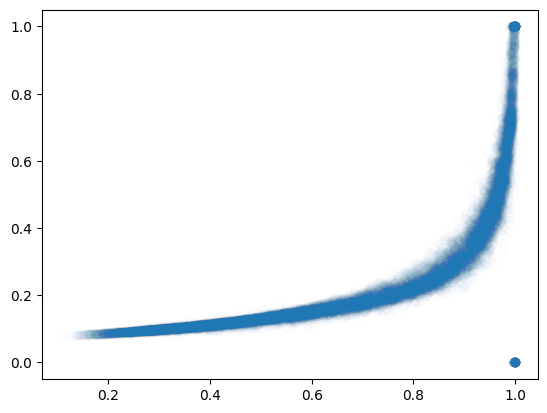

In [490]:
plt.scatter(
    padata.var['tau__tissue_cell_type'],
    st_tissuecelltype.max(axis=1),
    alpha=0.01,
)

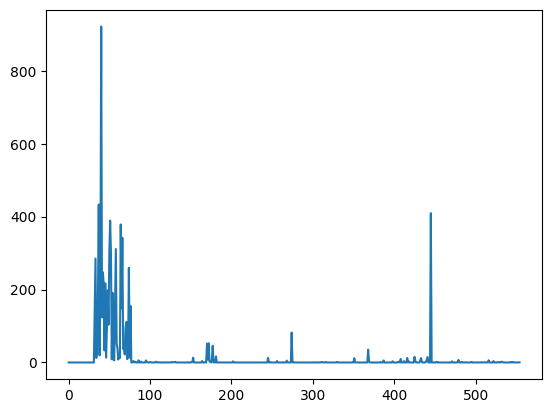

In [491]:
plt.plot(
    padata_cluster.layers['ntpm'][
        :,padata_cluster.var['gene_name'] == 'CCK'
    ],
)

In [492]:
padata.var.loc[
    padata.var['gene_name'] == 'VIP'
]

,gene_type,gene_name,tau__tissue,tau__cell_type,tau__cluster,tau__louvain,tau__tissue_cell_type,tau__pseudobulk
gene,,,,,,,,
ENSG00000146469,protein_coding,VIP,0.920117,0.95841,0.964639,0.899862,0.95806,0.971748


In [460]:
st_celltype.loc[
    padata.var['gene_name'] == 'CCK'
].T.iloc[:,0].sort_values(ascending=False).head(50)

excitatory_neurons                 0.460368
inhibitory_neurons                 0.449580
prostatic_glandular_cells          0.311927
syncytiotrophoblasts               0.307795
oligodendrocytes                   0.299337
muller_glia_cells                  0.288085
bipolar_cells                      0.245521
enteroendocrine_cells              0.158717
mucus_glandular_cells              0.156990
spermatogonia                      0.140478
gastric_mucus-secreting_cells      0.140084
rod_photoreceptor_cells            0.107019
alveolar_cells_type_1              0.104565
club_cells                         0.094825
basal_keratinocytes                0.094213
salivary_duct_cells                0.092520
smooth_muscle_cells                0.065298
suprabasal_keratinocytes           0.060834
breast_glandular_cells             0.060226
fibroblasts                        0.045088
alveolar_cells_type_2              0.044391
mixed_cell_types                   0.039135
macrophages                     

In [462]:
st_tissue.loc[
        padata_cluster.var['gene_name'] == 'CCK'
].T.iloc[:,0].sort_values(ascending=False).head(20)

brain              0.785910
eye                0.397541
prostate           0.189070
small_intestine    0.159372
liver              0.159024
skin               0.141860
breast             0.140224
tongue             0.137614
esophagus          0.123304
placenta           0.123200
salivary_gland     0.116997
lung               0.109614
testis             0.094223
skeletal_muscle    0.073170
fallopian_tube     0.054281
stomach            0.046001
pancreas           0.041073
bronchus           0.023798
vascular           0.021317
endometrium        0.021072
Name: ENSG00000187094, dtype: float64

In [20]:
padata.uns['meta'] = {}
padata.uns['meta']['comments'] = [
    'Cluster ids manually assigned with marker genes at HPA. Louvain assigned while pre-processing internally.'
]

In [21]:
padata.write_h5ad(
    settings.DATA_LOC / 'hpa' / 'all' / 'adata_pseuodobulk2.h5ad'
)

In [472]:
padata.obs[
    padata.obs['tissue'] == 'prostate'
]

,cluster,tissue,cell_type,louvain,tissue_cell_type,bulk_n_cells,bulk_total_cells,tpm_tmm_norm_factor
_sample_key,,,,,,,,
prostate__basal_prostatic_cells__15,prostate_c-3,prostate,basal_prostatic_cells,15,prostate__basal_prostatic_cells,55.0,178995.0,1.066100
prostate__basal_prostatic_cells__19,prostate_c-2,prostate,basal_prostatic_cells,19,prostate__basal_prostatic_cells,329.0,1417364.0,0.841048
prostate__basal_prostatic_cells__21,prostate_c-3,prostate,basal_prostatic_cells,21,prostate__basal_prostatic_cells,68.0,589628.0,0.994984
prostate__endothelial_cells__19,prostate_c-7,prostate,endothelial_cells,19,prostate__endothelial_cells,65.0,156843.0,0.961059
prostate__endothelial_cells__8,prostate_c-7,prostate,endothelial_cells,8,prostate__endothelial_cells,26.0,54811.0,1.305024
prostate__macrophages__19,prostate_c-6,prostate,macrophages,19,prostate__macrophages,37.0,99205.0,1.092229
prostate__macrophages__9,prostate_c-6,prostate,macrophages,9,prostate__macrophages,36.0,304505.0,0.898455
prostate__mixed_cell_types__19,prostate_c-1,prostate,mixed_cell_types,19,prostate__mixed_cell_types,852.0,3559005.0,0.651777
prostate__smooth_muscle_cells__19,prostate_c-10,prostate,smooth_muscle_cells,19,prostate__smooth_muscle_cells,32.0,48066.0,1.323998


In [473]:
atlas_adata.obs.loc[
    atlas_adata.obs['tissue'] == 'prostate',
    ['cell_type', 'louvain']
].value_counts().head(50)

cell_type                  louvain
mixed_cell_types           19         852
basal_prostatic_cells      19         329
t-cells                    8          108
basal_prostatic_cells      21          68
endothelial_cells          19          65
basal_prostatic_cells      15          55
t-cells                    15          42
                           19          38
macrophages                19          37
                           9           36
smooth_muscle_cells        19          32
endothelial_cells          8           26
basal_prostatic_cells      11          18
prostatic_glandular_cells  21          18
endothelial_cells          15          16
macrophages                3           16
club_cells                 21          13
                           11          11
basal_prostatic_cells      8           11
prostatic_glandular_cells  15          11
endothelial_cells          21          10
smooth_muscle_cells        6            9
prostatic_glandular_cells  8            9